<img src="zona_jobs.png">

# Trabajo Práctico N° 1: Análisis Exploratorio


## 1. Preparación de los datos

### 1.1. Importación de Librerías

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from dateutil.parser import parse
import numpy as np
import warnings
import datetime as dt
import cufflinks as cf
import plotly.plotly as py
warnings.filterwarnings('ignore')
import plotly
plotly.tools.set_credentials_file(username='soyarielruiz', api_key='Io0U7KvMLYpCw01a1vNJ')
cf.set_config_file(offline=False, world_readable=True, theme='pearl')

### 1.2. Carga de Archivos

In [2]:
# Carga de archivos
post_educacion = pd.read_csv('../data/fiuba_1_postulantes_educacion.csv', dtype = {
    'nombre': 'category',
    'estado': 'category'
})
post_gen_edad = pd.read_csv('../data/fiuba_2_postulantes_genero_y_edad.csv', dtype = {
    'sexo': 'category'    
})

vistas = pd.read_csv('../data/fiuba_3_vistas.csv', parse_dates=['timestamp'])
postulaciones = pd.read_csv('../data/fiuba_4_postulaciones.csv', parse_dates=['fechapostulacion'])
avisos_online = pd.read_csv('../data/fiuba_5_avisos_online.csv')

avisos_detalles = pd.read_csv('../data/fiuba_6_avisos_detalle.csv', dtype= {
    'nombre_zona': 'category',
    'ciudad': 'category',
    'tipo_de_trabajo': 'category',
    'nivel_laboral': 'category',
})

### 1.3. Ajustes de los Archivos antes de procesar

In [3]:
# Recorto la columna idpais ya que no es necesaria.
avisos_detalles.drop('idpais', axis=1, inplace=True)

In [4]:
# Agrupo las áreas parecidas.
areas_agrupadas = pd.read_csv('../extraData/areas_agrupadas.csv')
avisos_detalles = pd.merge(avisos_detalles, areas_agrupadas, how='inner', on='nombre_area')
avisos_detalles['nombre_area'] = avisos_detalles['nuevo_nombre_area']
avisos_detalles.drop('nuevo_nombre_area', axis=1, inplace=True)

In [5]:
# Convierto el nombre del area a category.
avisos_detalles['nombre_area'] = avisos_detalles['nombre_area'].astype('category')

In [6]:
# Agrego tipo categorico y modifico el tipo de dato de la fecha.
post_gen_edad.fechanacimiento = post_gen_edad.fechanacimiento.apply(pd.to_datetime, errors='coerce')

now = pd.Timestamp(dt.datetime.now())
pd.to_datetime(now)
post_gen_edad['edad'] = (now - pd.to_datetime(post_gen_edad['fechanacimiento'])).astype('<m8[Y]')

In [7]:
# Renombramos algunas columnas para unificar criterios.
vistas.rename(columns={"idAviso":"idaviso"}, inplace=True)
vistas.rename(columns={"timestamp":"fechavista"}, inplace=True)

# Cambiar el tipo de dato de la fecha de vista.
vistas[['fechavista']] = vistas[['fechavista']].apply(pd.to_datetime)

### 1.4. Ajustes de los Archivos antes de procesar

#### 1.4.1 Merges necesarios

In [124]:
usuarios_detalle                             = pd.merge(post_educacion, post_gen_edad, how='inner', left_on='idpostulante', right_on='idpostulante')
postulaciones_con_detalle_de_aviso           = pd.merge(postulaciones, avisos_detalles, how='inner', left_on='idaviso', right_on='idaviso')
postulaciones_con_detalle_de_aviso_y_usuario = pd.merge(postulaciones_con_detalle_de_aviso, usuarios_detalle, how='inner', left_on='idpostulante', right_on='idpostulante')
visitas_con_detalle_de_aviso                 = pd.merge(vistas, avisos_detalles, how='inner', left_on='idaviso', right_on='idaviso')
visitas_con_detalle_de_aviso_y_usuario       = pd.merge(visitas_con_detalle_de_aviso, usuarios_detalle, how='inner', left_on='idpostulante', right_on='idpostulante')

#### 1.4.2 Busqueda de Maxima Educación

In [8]:
# Asigno puntajes a los diferentes niveles educativos encontrados para poder 
# obtener asi la educacion mas valiosa (la de nivel academico mas alto) de cada postulante.
valores_educacion = pd.DataFrame({
    'nombre': ['Otro',  'Otro',  'Otro',  'Secundario',  'Secundario',  'Secundario',  'Terciario/Técnico', 'Universitario',  \
              'Terciario/Técnico', 'Universitario',  'Terciario/Técnico', 'Universitario',  'Posgrado', 'Master','Posgrado', \
              'Master','Posgrado', 'Master','Doctorado','Doctorado','Doctorado'],
    'estado': ['Abandonado', 'En Curso','Graduado','Abandonado', 'En Curso','Graduado','Abandonado', 'Abandonado', 'En Curso',\
              'En Curso','Graduado','Graduado','Abandonado', 'Abandonado', 'En Curso','En Curso','Graduado','Graduado',\
              'Abandonado', 'En Curso','Graduado'],
    'valor_educacion': [1 , 2 , 3 , 4, 5,6 ,7 ,8 ,9,10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]})

# Y le pongo las mismas categorias que ya habia encontrado previamente.
valores_educacion.nombre = valores_educacion.nombre.astype((pd.api.types.CategoricalDtype(post_educacion.nombre.cat.categories)))
valores_educacion.estado = valores_educacion.estado.astype((pd.api.types.CategoricalDtype(post_educacion.estado.cat.categories)))

In [9]:
# Hago el join para aplicar puntajes a las educaciones de los postulantes.
post_educacion = pd.merge(post_educacion, valores_educacion, how='inner', \
                          left_on=['nombre','estado'], right_on = ['nombre','estado'])

# Cuento cuantos registros tengo actualmente, para comprobar que no hay errores mas adelante.
# post_educacion.count()

In [10]:
# Busco la maxima educacion que tiene cada postulante.
max_post_educacion = post_educacion.groupby(['idpostulante'])['valor_educacion'].max().reset_index()

# Controlo cuantas lineas me devolvio.
# max_post_educacion.count()

In [11]:
# Hago el join para filtrar todas las educaciones que no me interesan, dejando solo la maxima educacion.
post_educacion = pd.merge(post_educacion, max_post_educacion,  how='inner', \
                          left_on=['idpostulante','valor_educacion'], \
                          right_on = ['idpostulante','valor_educacion'])

# post_educacion.count()

In [19]:
post_educacion_graph = post_educacion.groupby(['nombre', 'estado', 'valor_educacion'])['idpostulante'].count().reset_index()
post_educacion_graph['resumen'] = post_educacion_graph.nombre.astype('object') + ' ' + post_educacion_graph.estado.astype('object')
post_educacion_graph.sort_values('valor_educacion', inplace=True)
post_educacion_graph.reset_index()
post_educacion_graph.drop(['nombre', 'estado', 'valor_educacion'], axis=1, inplace=True)
post_educacion_graph.rename(columns= {'idpostulante' : 'Cantidad de Postulantes'}, inplace=True)

# post_educacion_graph.head(22)

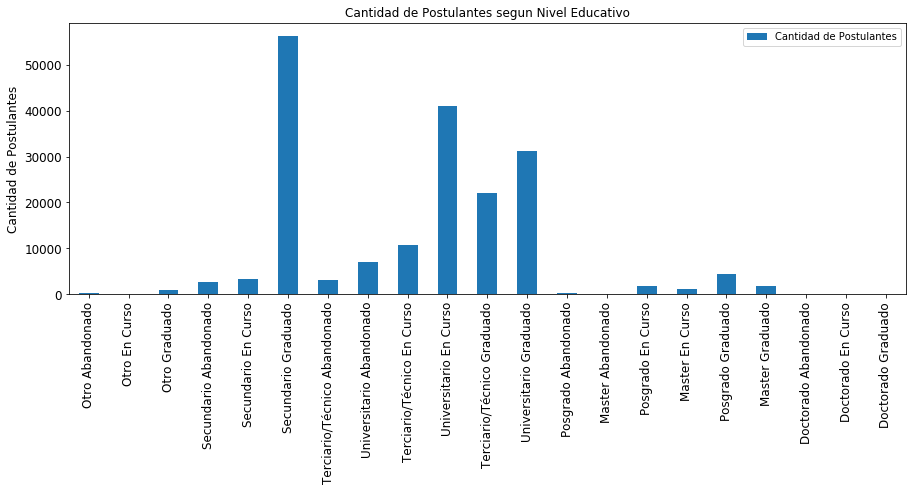

In [20]:
post_educacion_graph = post_educacion_graph[['resumen','Cantidad de Postulantes']].plot(kind='bar', x = 'resumen',                                                           
                                                           title ="Cantidad de Postulantes segun Nivel Educativo", 
                                                           figsize=(15, 5), legend=True, fontsize=12)
post_educacion_graph.set_xlabel("", fontsize=12)
post_educacion_graph.set_ylabel("Cantidad de Postulantes", fontsize=12)
plt.show()

## 2.1. Perfil de Postulantes

In [100]:
# Generamos un perfil sobre el postulante en base a los datos que tenemos, educacion, edad.
postulantes = pd.merge(max_post_educacion, post_gen_edad)
pd.to_datetime(postulantes['fechanacimiento'])
postulantes['edad'] = (now - pd.to_datetime(postulantes['fechanacimiento'])).astype('<m8[Y]')
pd.to_numeric(postulantes['edad'])

# Dejo solo los mayores de edad y menores a la edad de jubilacion
postulantes_filtrados_por_edad = postulantes.loc[(postulantes['edad'] >= 18) & (postulantes['edad'] <= 65)].reset_index()
postulantes_filtrados_por_edad.drop('index', inplace=True, axis=1)

postulantes_filtrados_por_edad.head()

,idpostulante,valor_educacion,fechanacimiento,sexo,edad
0,0z5VvGv,6,1987-10-18,MASC,30.0
1,0zB026d,11,1978-02-23,FEM,40.0
2,0zB03O9,9,1987-07-04,FEM,30.0
3,0zB08lq,6,1972-06-09,MASC,45.0
4,0zB0NWY,12,1987-09-20,FEM,30.0


In [101]:
# Creo un nuevo DataFrame de los postulantes y el area para el cual se postulan con mas frecuencia.
postulantes_areas = pd.merge(postulaciones, avisos_detalles, how='inner', on='idaviso')
postulantes_areas = pd.DataFrame(postulantes_areas.groupby(['idpostulante', 'nombre_area'])['idaviso'].count()).reset_index()
postulantes_areas = pd.DataFrame(postulantes_areas.sort_values(['idpostulante','idaviso'], ascending=False))
postulantes_areas = postulantes_areas.groupby(['idpostulante']).first()
postulantes_areas.drop('idaviso', inplace=True, axis=1)
postulantes_areas = postulantes_areas.reset_index()

In [102]:
postulantes_filtrados_por_edad.set_index('idpostulante', inplace=True)
postulantes_areas.set_index('idpostulante', inplace=True)

postulantes_filtrados_por_edad.index.name = None
postulantes_areas.index.name = None

In [103]:
postulantes_filtrados_por_edad = pd.concat([postulantes_filtrados_por_edad, postulantes_areas], axis=1)

In [104]:
postulantes_area_edad = postulantes_filtrados_por_edad.groupby(['nombre_area', 'edad']).count().reset_index()
postulantes_area_edad.drop(['valor_educacion', 'fechanacimiento', 'sexo'], inplace=True, axis=1)
postulantes_area_edad = postulantes_area_edad.groupby('nombre_area').agg(['min', 'max', 'mean'])
postulantes_area_edad.sort_values([('edad', 'min')], inplace=True)
postulantes_area_edad = postulantes_area_edad[postulantes_area_edad[('edad', 'min')] != postulantes_area_edad[('edad', 'max')]]
postulantes_area_edad

edad                 
                                          min   max       mean
nombre_area                                                   
Farmacéutica                             18.0  63.0  40.177778
Seguridad e Higiene                      18.0  64.0  40.066667
Salud                                    18.0  65.0  41.978723
Redes, Servidores y Soporte Técnico      18.0  61.0  39.500000
Recepcionista / Secretaria               18.0  65.0  41.500000
RRHH                                     18.0  65.0  41.500000
Química y Laboratorio                    18.0  63.0  38.690476
Seguros                                  18.0  64.0  37.850000
Promotoras/es                            18.0  48.0  27.000000
Planeamiento                             18.0  59.0  35.428571
Turismo y Hotelería                      18.0  54.0  34.393939
Pasantía / Trainee                       18.0  61.0  31.181818
Logística                                18.0  64.0  41.000000
Mantenimiento y Limpieza                 18.0  65.0  41.500000
Marketing                                18.0  60.0  38.292683
Producción                               18.0  64.0  41.000000
Gastronomía                              18.0  61.0  39.500000
Oficios y Profesiones                    18.0  59.0  37.600000
Servicios                                18.0  63.0  36.222222
Arquitectura y Diseño                    18.0  64.0  40.543478
Asesoría Legal y Comercio Internacional  18.0  65.0  40.111111
Asistente                                18.0  57.0  36.108108
Auditoría y Legal                        18.0  65.0  39.659091
Back Office                              18.0  61.0  36.216216
Comercial y Ventas                       18.0  65.0  41.500000
Comunicación                             18.0  60.0  38.121951
Construcción                             18.0  63.0  40.977778
Consultoria                              18.0  63.0  40.500000
Contabilidad y Administración            18.0  65.0  41.500000
Control y Calidad                        18.0  61.0  38.268293
Telecomunicaciones                       18.0  56.0  35.303030
Tecnología y Sistemas                    18.0  63.0  40.500000
Dirección y Liderazgo                    18.0  64.0  41.456522
Educación                                18.0  65.0  39.704545
Otros                                    18.0  62.0  39.863636
Análisis Funcional                       19.0  61.0  40.000000
Ingeniería en Alimentos                  19.0  59.0  37.483871
Corporate Finance / Banca Inversión      19.0  56.0  36.000000
Desarrollo de Negocios                   19.0  61.0  38.538462
Jóvenes Profesionales                    19.0  52.0  32.538462
Ingeniería de Procesos                   19.0  55.0  35.606061
Ingeniería Oficina Técnica / Proyecto    19.0  62.0  40.675000
Mineria/Petroleo/Gas                     19.0  65.0  41.111111
Ingeniería Electromecánica               21.0  65.0  42.292683
Organización y Métodos                   21.0  57.0  36.560000
Ingeniería Civil                         21.0  65.0  42.046512
Infraestructura                          21.0  58.0  36.892857
Ingeniería Agrónoma                      22.0  62.0  36.964286
Media Planning                           23.0  50.0  34.200000
Evaluación Económica                     23.0  44.0  33.230769
Independientes                           25.0  56.0  37.642857
Ingeniería de Ventas                     26.0  63.0  40.277778
Operaciones                              27.0  55.0  42.428571
Medio Ambiente                           27.0  56.0  38.857143

### 2.2. Analisis de los Avisos

#### 2.2.1 Cantidad de avisos en los diferentes niveles laborales


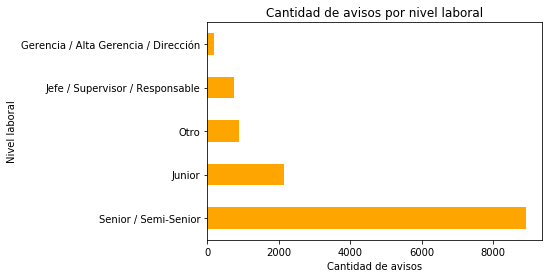

In [106]:
ax = plt.gca()
avisos_detalles.groupby('nivel_laboral')['nivel_laboral'].count().sort_values(ascending=False)\
               .plot(kind='barh', color="orange", title="Cantidad de avisos por nivel laboral");
ax.set_xlabel('Cantidad de avisos')
ax.set_ylabel('Nivel laboral');

#### 2.2.2 Cuales son las areas laborales con mayor cantidad de avisos?


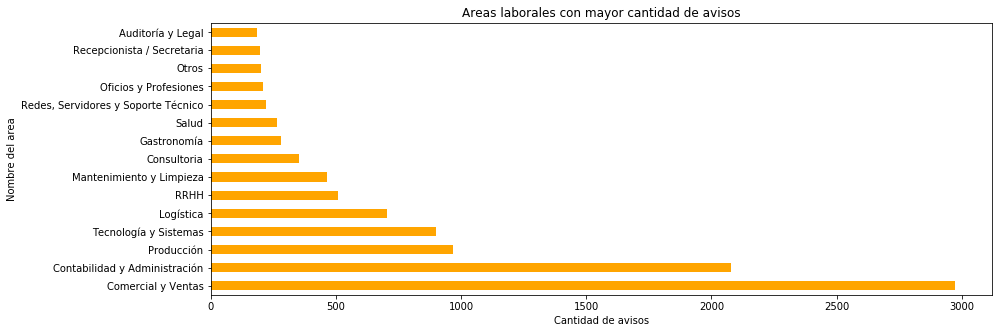

In [112]:
ax = plt.gca()
avisos_detalles.groupby('nombre_area')['nombre_area'].count().sort_values(ascending=False).head(15) \
               .plot(kind='barh', color='orange',figsize=(14,5), title="Areas laborales con mayor cantidad de avisos");
ax.set_xlabel('Cantidad de avisos');
ax.set_ylabel('Nombre del area');

#### 2.2.3 Areas Laborales con Menor Cantidad de Avisos

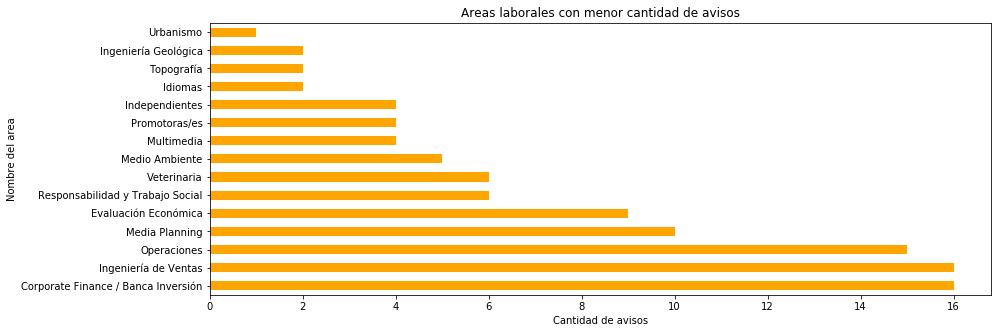

In [117]:
ax = plt.gca()
avisos_detalles.groupby('nombre_area')['nombre_area'].count().sort_values(ascending=True).head(15).sort_values(ascending=False)\
               .plot(kind='barh', figsize=(14,5), color='orange', title='Areas laborales con menor cantidad de avisos');
ax.set_xlabel('Cantidad de avisos');
ax.set_ylabel('Nombre del area');

#### 2.2.4 Cuales son las Areas Laborales con Mayor Cantidad de Postulaciones

In [ ]:
ax = plt.gca()
postulaciones_con_detalle_de_aviso.groupby('nombre_area')['nombre_area'].count().sort_values(ascending=False).head(30)\
                                     .plot(kind='barh', figsize=(15,12), color='orange', title='Areas laborales con la mayor cantidad de postulaciones');
ax.set_xlabel('Cantidad de postulaciones');
ax.set_ylabel('Nombre del area');

In [14]:
post_educacion.head()

,idpostulante,nombre,estado,valor_educacion
0,NdJl,Posgrado,En Curso,15
1,axaPJ,Posgrado,En Curso,15
2,Z48mz,Posgrado,En Curso,15
3,a4zEZ,Posgrado,En Curso,15
4,6AWqO,Posgrado,En Curso,15


In [15]:
post_gen_edad.head()

,idpostulante,fechanacimiento,sexo,edad
0,NM5M,1970-12-03,FEM,47.0
1,5awk,1962-12-04,FEM,55.0
2,ZaO5,1978-08-10,FEM,39.0
3,NdJl,1969-05-09,MASC,48.0
4,eo2p,1981-02-16,MASC,37.0


In [16]:
vistas.head()

,idaviso,fechavista,idpostulante
0,1111780242,2018-02-23 18:38:13.187,YjVJQ6Z
1,1112263876,2018-02-23 18:38:14.296,BmVpYoR
2,1112327963,2018-02-23 18:38:14.329,wVkBzZd
3,1112318643,2018-02-23 18:38:17.921,OqmP9pv
4,1111903673,2018-02-23 18:38:18.973,DrpbXDP


In [17]:
postulaciones.head()

,idaviso,idpostulante,fechapostulacion
0,1112257047,NM5M,2018-01-15 16:22:34
1,1111920714,NM5M,2018-02-06 09:04:50
2,1112346945,NM5M,2018-02-22 09:04:47
3,1112345547,NM5M,2018-02-22 09:04:59
4,1112237522,5awk,2018-01-25 18:55:03


In [18]:
avisos.head()

NameError: name 'avisos' is not defined

In [ ]:
avisos_detalles.head()

In [ ]:
avisos_detalles.columns.values

In [ ]:
avisos_detalles.describe()

In [ ]:
#relacion avisos vs postulantes
post_avisos = pd.merge(avisos_detalles, postulaciones, on='idaviso', how='inner')
post_avisos.count()

In [ ]:
#avisos que no tienen postulantes
avisos_sin_post = pd.merge(avisos_detalles, postulaciones, on='idaviso', how='left')
avisos_sin_post = avisos_sin_post[avisos_sin_post['idpostulante'].isnull()]
avisos_sin_post.count()

In [ ]:
#avisos que tienen postulantes
avisos_con_post = avisos_detalles.merge(avisos_sin_post, how='left', on='idaviso')
avisos_con_post = avisos_con_post[avisos_con_post['titulo_y'].isnull()]
avisos_con_post.count()

In [ ]:
#avisos totales
avisos_detalles.count()

In [ ]:
avisos.count()

In [ ]:
postulaciones.count()

In [ ]:
#cantidad de postulaciones por postulante
cant_post = postulaciones.loc[:,['idpostulante']]
cant_post = cant_post.merge(post_gen_edad,how='inner',on='idpostulante')
cant_post.head()

In [ ]:
cant_post = cant_post.loc[:,['idpostulante']]
cant_post_group = cant_post.groupby(['idpostulante']).size()
cant_post_group.head()

In [ ]:
cant_post_group_sort = cant_post_group.sort_values(ascending=False)
cant_post_group_sort.head()

In [ ]:
#agrego el sexo y fechanacimiento
cant_post_sexo = pd.DataFrame(cant_post_group_sort).reset_index()
cant_post_sexo = cant_post_sexo.merge(post_gen_edad, how='inner', on='idpostulante')
cant_post_sexo[["idpostulante", "cantidad_postulaciones", "fechanacimiento", "sexo"]] = \
    cant_post_sexo[["idpostulante", 0, "fechanacimiento", "sexo"]]

cant_post_sexo= cant_post_sexo[["idpostulante", "cantidad_postulaciones", "fechanacimiento", "sexo"]]  
cant_post_sexo.head(15)